<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/DR_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinnopathy | Machine Learning Project

### Libraries

In [2]:
import numpy as np
import pandas as pd
import random, os
import shutil
import kagglehub
import os
import shutil
import cv2
import random
import pickle

import seaborn as sns

import tensorflow as tf
from tensorflow import lite
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy

import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

### Connecting with Kaggle

In [3]:
# Install Kaggle API
!pip install -q Kaggle
!apt-get update
!apt-get install tree -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,086 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,264 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,780 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backport

### Setting up Kaggle & Downloading the Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Setting up Kaggle credentials
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
 87% 372M/427M [00:04<00:00, 62.9MB/s]
100% 427M/427M [00:04<00:00, 106MB/s] 


In [5]:
# List directory after unzipping
print("Top-level files and folders:")
print(os.listdir())

Top-level files and folders:
['.config', 'train.csv', 'gaussian_filtered_images', 'drive', 'sample_data']


### Loading the Data

In [6]:
# Loading the CSV file into a pandas DataFrame
path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"
df = pd.read_csv("/content/train.csv")

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
print(df.head())

# Image folder root
image_root = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')

# Output base folder
output_root = "/content/processed"

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR


### Creating Paths

In [7]:
# Reviewing the paths
path = "/content" # Corrected path
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /content
Contents of the folder:
['.config', 'train.csv', 'gaussian_filtered_images', 'drive', 'sample_data']


In [8]:
# Images
images = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')
print("Contents of the folder:", os.listdir(images))

Contents of the folder: ['Moderate', 'export.pkl', 'Proliferate_DR', 'No_DR', 'Mild', 'Severe']


In [9]:
# Loading the CSV
print(df.head(10))

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR
5  0083ee8054ee          4          DR  Proliferate_DR
6  0097f532ac9f          0       No_DR           No_DR
7  00a8624548a9          2          DR        Moderate
8  00b74780d31d          2          DR        Moderate
9  00cb6555d108          1          DR            Mild


### Viewing Data Distrubution

<Axes: xlabel='type'>

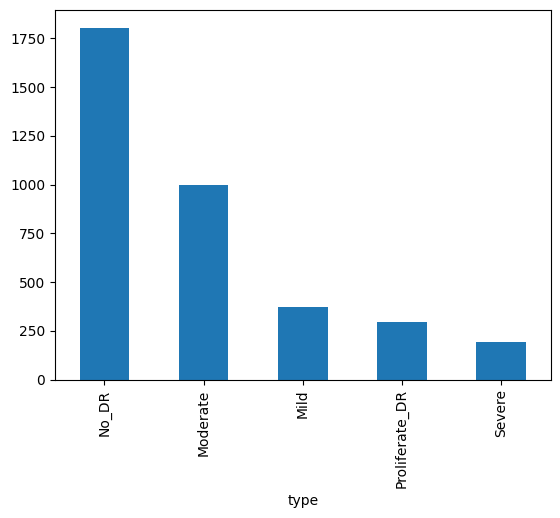

In [10]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='binary_type'>

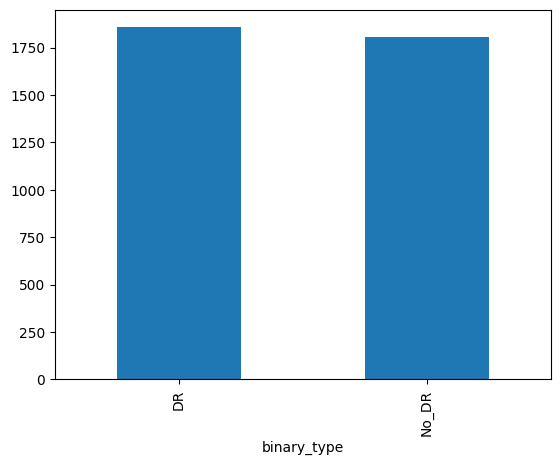

In [11]:
df['binary_type'].value_counts().plot(kind='bar')

### Split Data to Train, Test & Validation test

In [12]:
# Split into stratified train, val, and test sets
train_mid, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_mid, test_size = 0.15 / (1 - 0.15), stratify = train_mid['type'])

print("Train Set:")
print(train['type'].value_counts(), '\n')

print("Test Set:")
print(test['type'].value_counts(), '\n')

print("Val Set:")
print(val['type'].value_counts(), '\n')

Train Set:
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

Test Set:
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

Val Set:
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



### Creating Working Directories for Train, Validation and Test

In [13]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [14]:
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"
print(os.listdir(src_dir))

['Moderate', 'export.pkl', 'Proliferate_DR', 'No_DR', 'Mild', 'Severe']


### Setting up the Directory

In [15]:
# Setting up the source directory
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"  # actual path in Colab

# Setting up destination working directories
base_dir = "/content/processed"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Recreateing destination folders
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Defining a function to copy the data
def copy_split(df, split_dir):
    for _, row in df.iterrows():
        diagnosis = row['type']
        binary = row['binary_type']
        filename = row['id_code'] + ".png"

        srcfile = os.path.join(src_dir, diagnosis, filename)
        dst_folder = os.path.join(split_dir, binary)

        os.makedirs(dst_folder, exist_ok=True)

        if os.path.exists(srcfile):
            shutil.copy(srcfile, dst_folder)
        else:
            print(f"[Missing] {srcfile}")

# Copying all splits
copy_split(train, train_dir)
copy_split(val, val_dir)
copy_split(test, test_dir)

#### Viewing a Sample of the Train Set

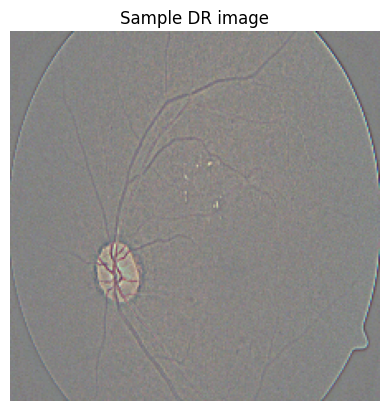

In [16]:
sample_folder = "/content/processed/train/DR"
sample_images = os.listdir(sample_folder)
img_path = os.path.join(sample_folder, random.choice(sample_images))

img = imread(img_path)
plt.imshow(img)
plt.title("Sample DR image")
plt.axis("off")
plt.show()

### Setting up the Generator

In [17]:
# Setting up ImageDataGenerator for train/val/test
train_path = '/content/processed/train'
val_path = '/content/processed/val'
test_path = '/content/processed/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32
patience = 5 # number of epochs to wait to adjust if value does not improvee
stop_patience = 7  # number of epochs to wait before stopping the training if the value does not improve
epochs = 30

# Set up the training data generator using flow_from_directory
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    train_path,
    target_size=img_size,
    class_mode='categorical', # Use 'categorical' for binary classification with 2 classes
    shuffle = True,
    batch_size=batch_size
)

# Setting up the validation data generator using flow_from_directory
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    val_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = True,
    batch_size=batch_size
)

# Seting up the test data generator using flow_from_directory
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    test_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = False,
    batch_size=batch_size
)

print("Data generators train_batches, val_batches, and test_batches are now defined.")

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Data generators train_batches, val_batches, and test_batches are now defined.


In [32]:
# # Function to save the test images to google drive that later can be used for the streamlit app
# test_folder = '/content/processed/train'
# destination_test_folder = "/content/drive/MyDrive/diabetic_retinopathy_images/test"

# os.makedirs(destination_test_folder, exist_ok=True)
# shutil.copytree(test_folder, destination_test_folder, dirs_exist_ok=True)

# print("Images copied to Google Drive.")

Images copied to Google Drive.


### Plotting the Images for Test

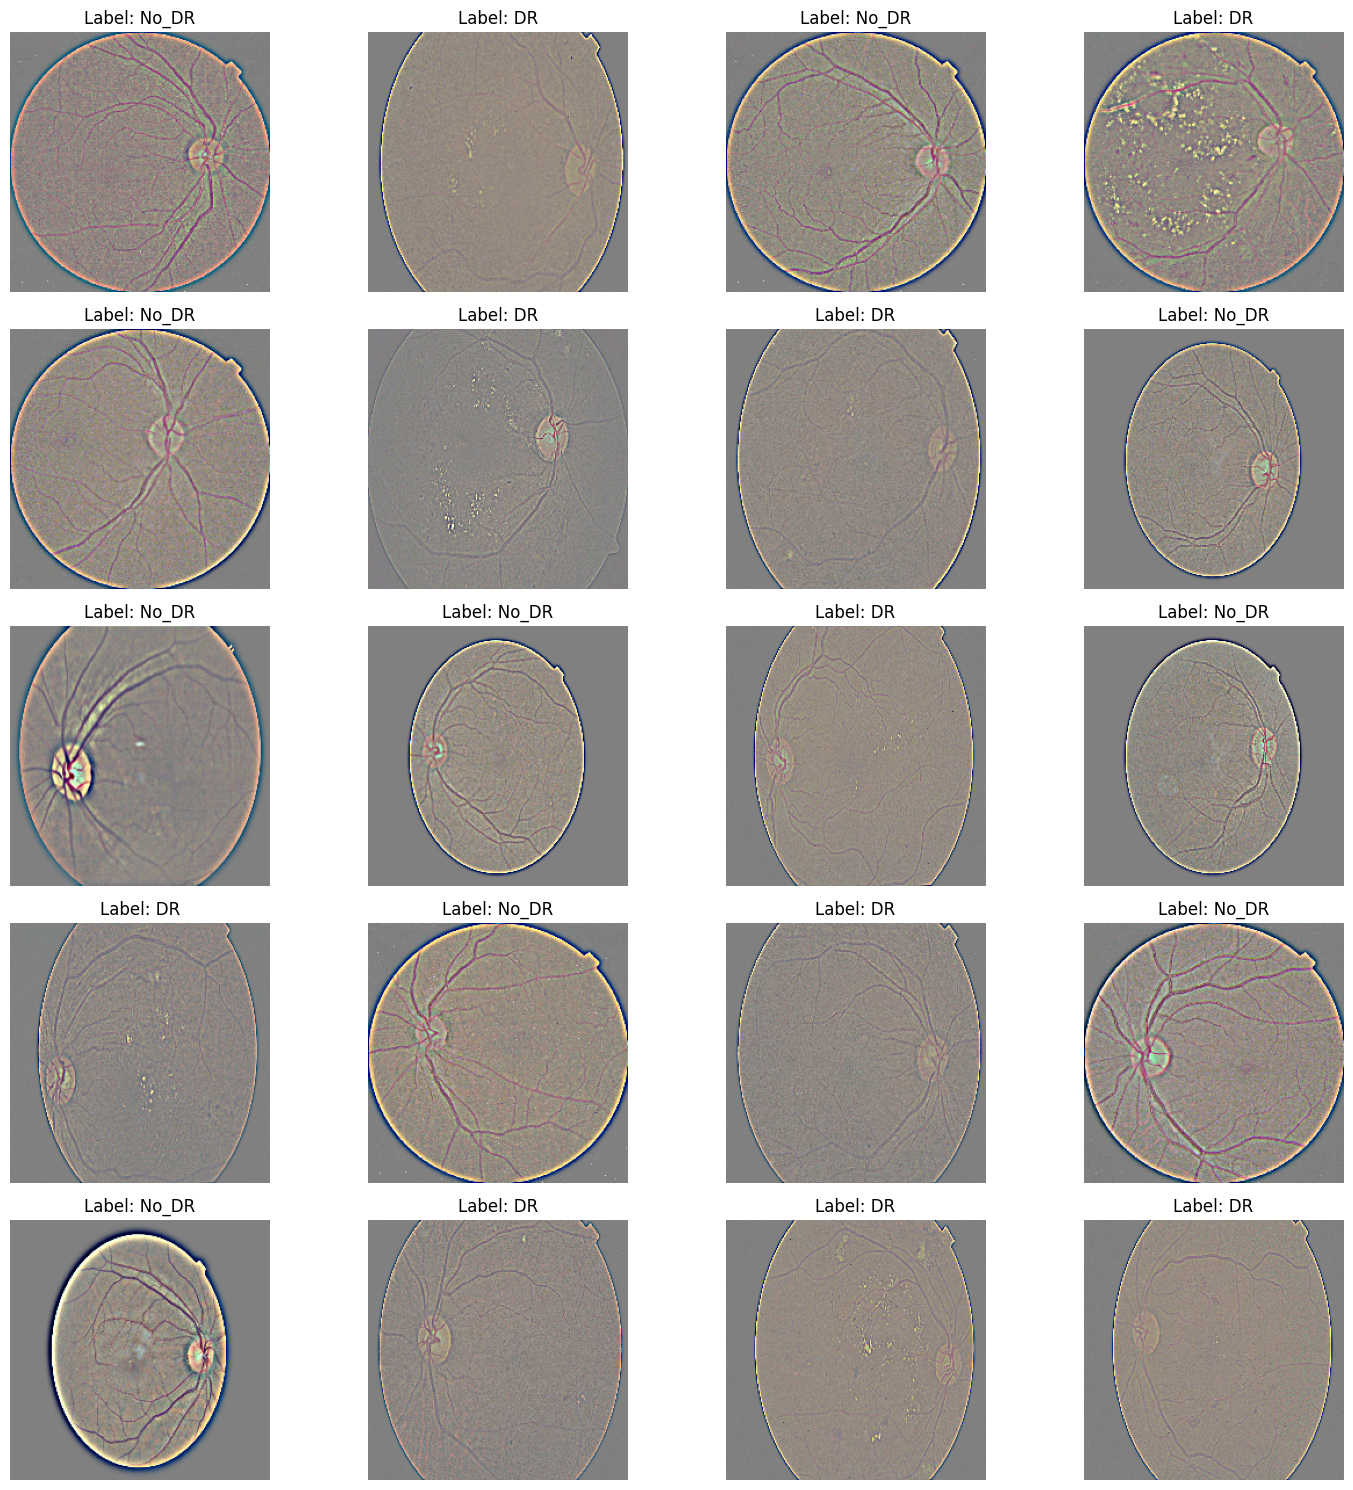

In [18]:
# Image Batching
images, labels = next(train_batches)

# Class names from the generator
class_names = list(train_batches.class_indices.keys())

# Ploting 20 images to review in the training set
num_images_to_show = min(20, len(images))
plt.figure(figsize=(15, 15))

for i in range(num_images_to_show):
    plt.subplot(5, 4, i + 1)
    plt.imshow(images[i])
    # Get the true label
    true_label_index = np.argmax(labels[i])
    true_label = class_names[true_label_index]
    plt.title(f"Label: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Building the Model & Learn

In [19]:
# Call backs
# callbacks = [MyCallback(model=model, patience = patience, stop_patience = stop_patience, epochs =epochs)]

# Building the model
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches, epochs=epochs, validation_data = val_batches)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - acc: 0.8264 - loss: 0.4719 - val_acc: 0.5073 - val_loss: 0.6909
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - acc: 0.8889 - loss: 0.2746 - val_acc: 0.5073 - val_loss: 0.7208
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - acc: 0.9076 - loss: 0.2445 - val_acc: 0.5073 - val_loss: 0.7144
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - acc: 0.9187 - loss: 0.2292 - val_acc: 0.5855 - val_loss: 0.6698
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - acc: 0.9269 - loss: 0.2102 - val_acc: 0.7036 - val_loss: 0.4573
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 0.9217 - loss: 0.2173 - val_acc: 0.9182 - val_loss: 0.2779
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - acc: 0.9341 - loss: 0.1890 - val_acc: 0.9255 - val_loss: 0.2170
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - acc: 0.9327 - loss: 0.1908 - val_acc: 0.9309 - val_loss: 0.1983
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step 

### Evaluating the Model

In [20]:
# Evaluate the model on the test set
print("Evaluating model on the test set:")
loss, acc = model.evaluate(test_batches, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Evaluating model on the test set:
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - acc: 0.9419 - loss: 0.1822
Test Loss: 0.1910
Test Accuracy: 0.9400


### Creating Confusion Matrix



In [21]:
# Getting the true labels from the test_batches generator
test_batches.reset()
true_labels = test_batches.classes
class_names = list(test_batches.class_indices.keys())

# Get the model's predictions on the test data
predictions = model.predict(test_batches, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(report)

Confusion Matrix:
[[259  20]
 [ 13 258]]

Classification Report:
              precision    recall  f1-score   support

          DR       0.95      0.93      0.94       279
       No_DR       0.93      0.95      0.94       271

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



### Plotting the Confusion Matrix

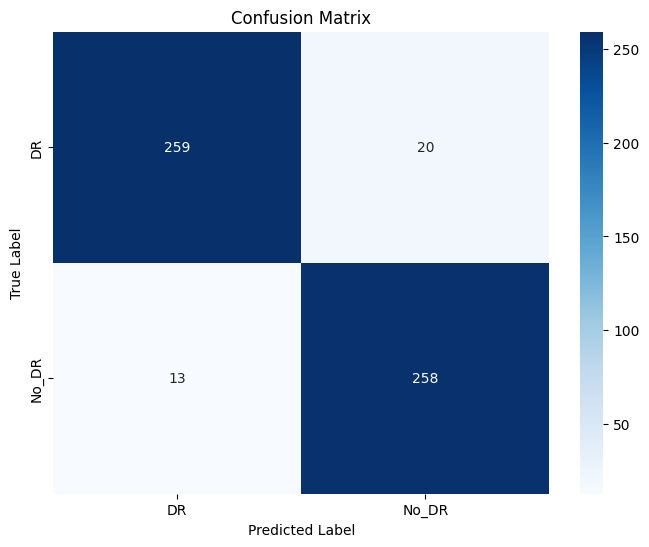

In [22]:
# Plotting the confusion Matrix for better overview

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Reasoning**:
The confusion matrix and classification report were not successfully defined in the previous attempt.



### Saving the Model
Saving the Model as .keras

In [29]:
# Define path to Google Drive folder
drive_folder_path = '/content/drive/MyDrive/trained_models'

# Create folder if it doesn't exist
os.makedirs(drive_folder_path, exist_ok=True)

# Define destination path
destination_path = os.path.join(drive_folder_path, 'CNN_model.keras')

# Save the model directly to Google Drive
try:
    model.save(destination_path)
    print(f"Model successfully saved to {destination_path}")
except Exception as e:
    print(f"An error occurred: {e}")


Model successfully saved to /content/drive/MyDrive/trained_models/CNN_model.keras


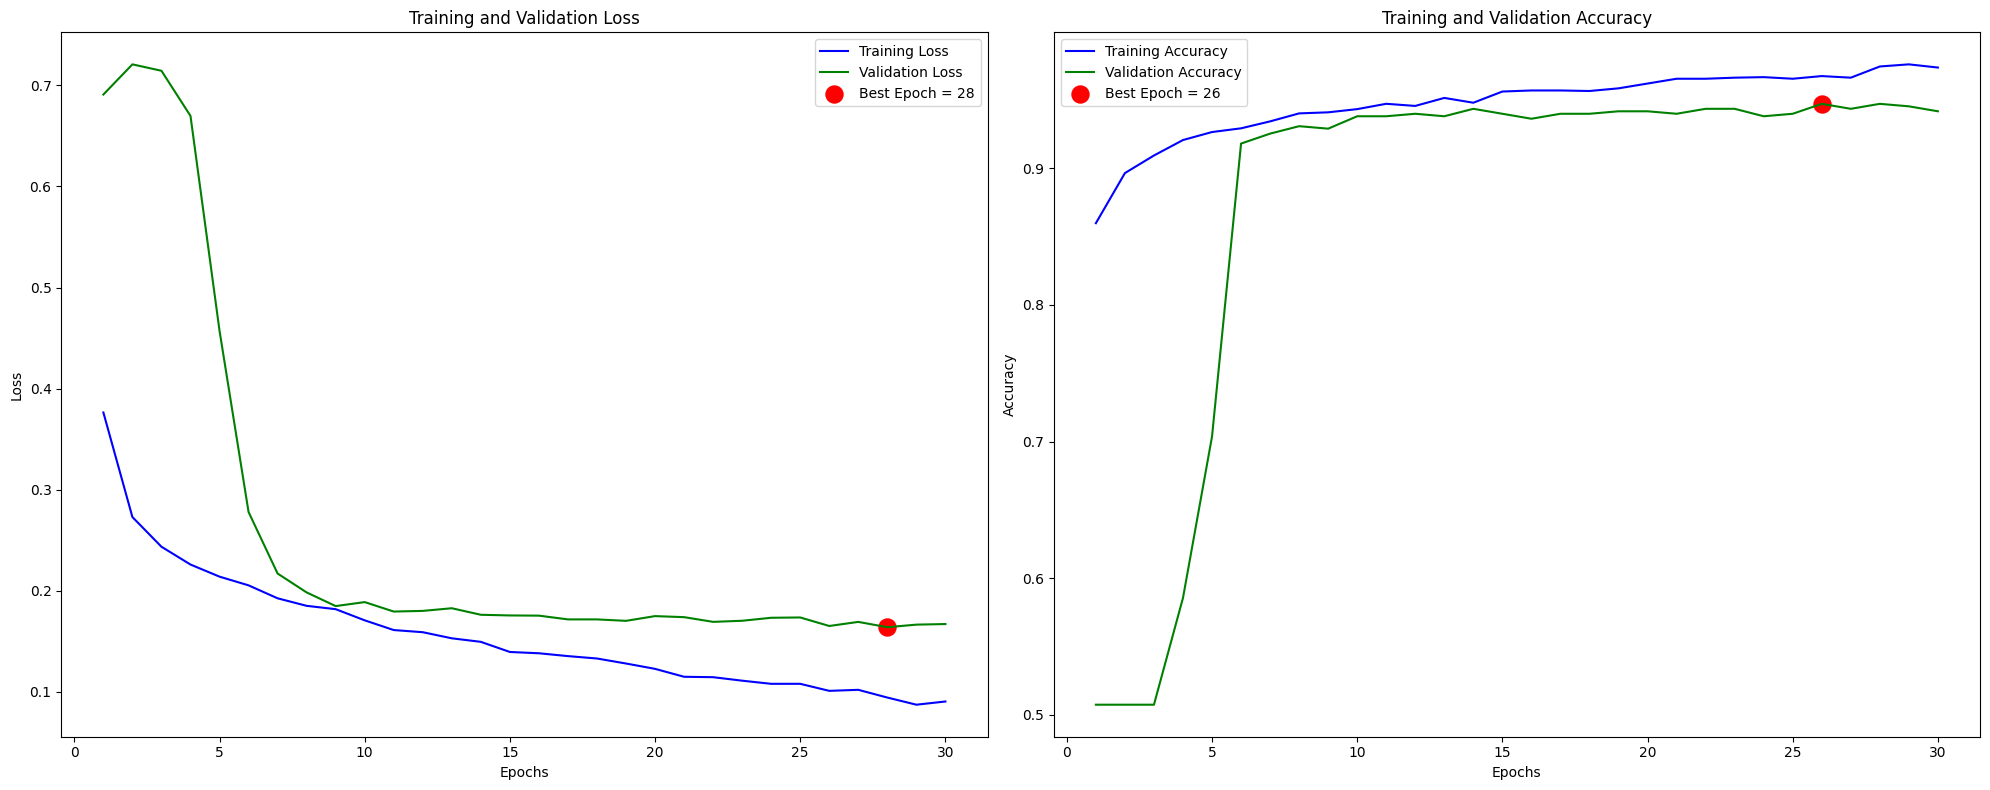

In [24]:
# Displaying Model Pereformance
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
epochs = [i+1 for i in range(len(train_acc))]
loss_label = f"Best Epoch = {str(index_loss+1)}"
acc_label = f"Best Epoch = {str(index_acc + 1)}"

# Plotting Training History
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'g', label= "Validation Loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c= "red", label = loss_label)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'g', label= "Validation Accuracy")
plt.scatter(index_acc + 1, acc_highest, s=150, c= "red", label = acc_label)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Diabetes Retinopathy Detection

### Prediction on all images

In [25]:
def predict_on_all_images_in_dir(directory_path, model):
    if not os.path.exists(directory_path):
        print(f"Error: Directory not found at {directory_path}")
        return

    image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    if not image_files:
        print(f"Error: No image files found in {directory_path}")
        return

    print(f"Predicting images in: {directory_path}")
    true_class = os.path.basename(directory_path)
    print(f"True Class for this directory is: {true_class}")

    correct_predictions = 0
    total_images = len(image_files)

    for image_file in image_files:
        path = os.path.join(directory_path, image_file)

        img = cv2.imread(path)

        if img is None:
            print(f"Warning: I can'tload image from {path}. Please check.")
            continue

        RGBimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        RGBimg = cv2.resize(RGBimg, (224, 224))

        image = np.array(RGBimg) / 255.0
        prediction = model.predict(np.array([image]))
        per = np.argmax(prediction, axis=1)[0]

        predicted_class = "DR" if per == 0 else "No_DR"

        print(f"  Image: {image_file}, Predicted Class: {predicted_class}")

        if true_class == predicted_class:
            correct_predictions += 1

    accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
    print(f"\nSummary for {directory_path}:")
    print(f"Total Images: {total_images}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")

# Directories to test out
test_no_dr_dir = "/content/processed/test/No_DR"
test_dr_dir = "/content/processed/test/DR"

# Predicting on images in the No_DR directory
predict_on_all_images_in_dir(test_no_dr_dir, model)

print("-" * 30) # Separator

# Predict on images in the DR directory
predict_on_all_images_in_dir(test_dr_dir, model)

Predicting images in: /content/processed/test/No_DR
True Class for this directory is: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
  Image: 2a4520f1f9a3.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Image: 5ba156a35ff2.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Image: 7828dd083cdc.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Image: 98d41bce73a8.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Image: 2b3a4a81d748.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Image: 3325b1fe55d2.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Image: 77a1f1398fdb.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Image: 436e7a7af761.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Image: bb85097857fa.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
  Image: 44976c3b11a6.png, Predicted Class: No_DR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

### Predicting With a Random Image

Predicting on random image: b3819a805dca.png
True Class: DR


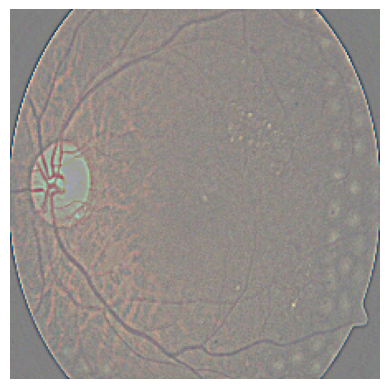

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Class: DR
Prediction is CORRECT!


In [26]:
def predict_class_random_from_dir(directory_path):
  if not os.path.exists(directory_path):
    print(f"Error: Directory not found at {directory_path}")
    return

  image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

  if not image_files:
    print(f"Error: No image files found in {directory_path}")
    return

  # Randomly select an image in the file
  selected_image_file = random.choice(image_files)
  path = os.path.join(directory_path, selected_image_file)
  print(f"Predicting on random image: {selected_image_file}")

  # Extract the true class from the directory path
  true_class = os.path.basename(directory_path)
  print(f"True Class: {true_class}")

  img = cv2.imread(path)

  if img is None:
    print(f"Error: Could not load image from {path}. Check file integrity.")
    return

  RGBimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  RGBimg = cv2.resize(RGBimg, (224, 224))
  plt.imshow(RGBimg)
  plt.axis("off")
  plt.show()

  image = np.array(RGBimg) / 255.0
  # Using the trained model
  prediction = model.predict(np.array([image]))
  per=np.argmax(prediction, axis=1)[0]

  # Corrected logic to match the true_class string format
  predicted_class = "DR" if per == 0 else "No_DR"
  print(f"Predicted Class: {predicted_class}")

  # Compare true and predicted classes
  if true_class == predicted_class:
      print("Prediction is CORRECT!")
  else:
      print("Prediction is INCORRECT.")

# List of directories to choose from & randomly select and predict from an image
test_directories = ["/content/processed/test/No_DR", "/content/processed/test/DR"]
selected_directory = random.choice(test_directories)
predict_class_random_from_dir(selected_directory)